In [6]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import shap

In [2]:
df = pd.read_excel("scCO2_all_data(curated).xlsx")

In [4]:
CDK_desc = pd.read_csv("CO2_CDKdesc_Total.csv")
list_descs = pd.read_csv("CDK_DES.csv")["Name"]
des_cdk = CDK_desc[list_descs].fillna(0)

In [7]:
y = df["Lg(y)"]
X=pd.concat([df["T (K)"], df["P (bar)"], df["Melting Point"], df["dHvap (kJ/mol)"], df["g (gcm3)"], df["dG"], des_cdk], axis=1)

In [8]:
n_samples = X.shape[0]
all_leverages = np.zeros(n_samples)
all_residuals = np.zeros(n_samples)

In [9]:
class UniqueGroupKFold:
    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_groups = np.unique(groups)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(unique_groups)
        
        fold_size = len(unique_groups) // self.n_splits
        
        for i in range(self.n_splits):
            if i == self.n_splits - 1:
                test_groups = unique_groups[i * fold_size:]
            else:
                test_groups = unique_groups[i * fold_size: (i + 1) * fold_size]
            
            test_indices = np.where(np.isin(groups, test_groups))[0]
            train_indices = np.where(~np.isin(groups, test_groups))[0]
            
            if len(test_indices) > 0 and len(train_indices) > 0:
                yield train_indices, test_indices

In [10]:
cv = UniqueGroupKFold(n_splits=5, shuffle=True, random_state=4321)

In [12]:
X=X.values
for fold, (train_idx, test_idx) in enumerate(cv.split(X, groups=df['SMILES_Canonical'])):
    print(f'fold {fold+1}/5...')
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = CatBoostRegressor(verbose=0)
    model.fit(X_train, y_train)
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    shap_matrix = np.abs(shap_values)  
    leverage_shap = shap_matrix.sum(axis=1) 
    
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    std_residuals = residuals / np.std(residuals)  
    
    all_leverages[test_idx] = leverage_shap 
    all_residuals[test_idx] = std_residuals 

fold 1/5...
fold 2/5...
fold 3/5...
fold 4/5...
fold 5/5...


In [13]:
h_star = np.percentile(all_leverages, 95)  # Threshold for SHAP leverages
out_of_leverage = np.sum(all_leverages > h_star)
out_of_residuals = np.sum((all_residuals < -3) | (all_residuals > 3))

print(f'Number of points beyond SHAP leverage threshold (h*): {out_of_leverage}')
print(f'Number of points beyond standardized residual boundaries (±3): {out_of_residuals}')

Number of points beyond SHAP leverage threshold (h*): 1539
Number of points beyond standardized residual boundaries (±3): 340


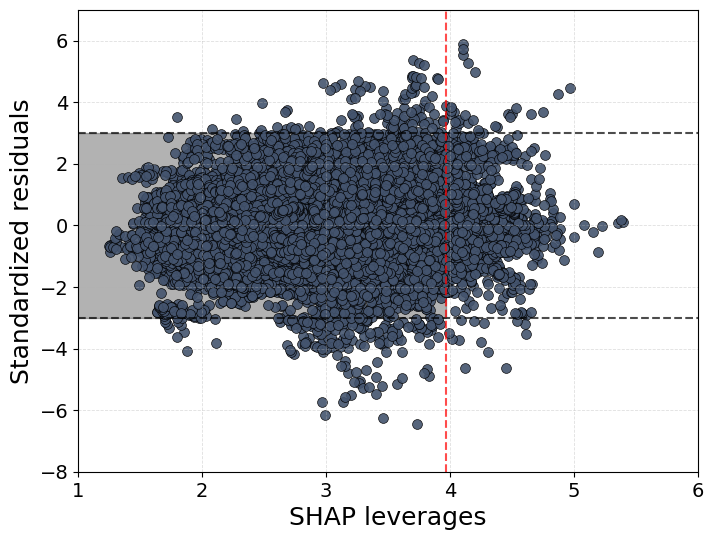

In [15]:
plt.figure(figsize=(8, 6))

plt.fill_between(
    x=[0, h_star],
    y1=-3, 
    y2=3, 
    color='black',
    alpha=0.3 
)
plt.scatter(
    all_leverages, 
    all_residuals, 
    s=50, 
    c='#44546e', 
    edgecolors='black', 
    linewidth=0.5,  
    alpha=0.9
)
plt.axhline(y=3, color='black', linestyle='--', alpha=0.7)
plt.axhline(y=-3, color='black', linestyle='--', alpha=0.7)
plt.axvline(x=h_star, color='red', linestyle='--', alpha=0.7)
plt.xlabel('SHAP leverages',fontsize=18)
plt.ylabel('Standardized residuals', fontsize=18)

plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.4)
plt.xlim(1, 6)  
plt.ylim(-8, 7) 
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()